In [3]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#lesson: pply ANN to any type of tabular dataset, feature engineering, embeddings
#dropout layers
df = pd.read_csv('../Data/NYCTaxiFares.csv')
#both categorical and continuous data
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [4]:
#features: lat and longi don't work well in the dataset; need a new variable

## Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [6]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [7]:
df['dist_km'] = haversine_distance(df,'pickup_latitude','pickup_longitude',
                           'dropoff_latitude', 'dropoff_longitude')
#use df.columns to check

In [8]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [9]:
df.info()#check the data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
pickup_datetime      120000 non-null object
fare_amount          120000 non-null float64
fare_class           120000 non-null int64
pickup_longitude     120000 non-null float64
pickup_latitude      120000 non-null float64
dropoff_longitude    120000 non-null float64
dropoff_latitude     120000 non-null float64
passenger_count      120000 non-null int64
dist_km              120000 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


In [10]:
#features: convert the string into a datetime obj in pd
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
pickup_datetime      120000 non-null datetime64[ns, UTC]
fare_amount          120000 non-null float64
fare_class           120000 non-null int64
pickup_longitude     120000 non-null float64
pickup_latitude      120000 non-null float64
dropoff_longitude    120000 non-null float64
dropoff_latitude     120000 non-null float64
passenger_count      120000 non-null int64
dist_km              120000 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [11]:
my_time = df['pickup_datetime'][0]
my_time #tab + shift gives more params

Timestamp('2010-04-19 08:17:56+0000', tz='UTC')

In [12]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime']) - pd.Timedelta(hours=4)

In [13]:
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')#where condition, am-True, pm-False
#for week, you can also do df['Weekday'] = df['EDTdate'].dt.dayofweek
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [14]:
#deal with some categorical variables into NN
cat_cols = ["Hour","AMorPM","Weekday"]
#df.column
cont_cols = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km']

In [15]:
y_col = ['fare_class']
y_col

['fare_class']

In [16]:
#convert cat to cont in pd
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AMorPM                            object
Weekday                           object
dtype: object

In [17]:
for cat in cat_cols:
    #reset the categorical vvariables
    df[cat] = df[cat].astype('category')

In [18]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                            category
AMorPM                          category
Weekday                         category
dtype: object

In [19]:
df['Hour'].head() #replace with AMorPM and Weekday

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [20]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [21]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [41]:
df['AMorPM'].cat.codes

0         0
1         0
2         0
3         1
4         1
5         0
6         1
7         0
8         0
9         1
10        1
11        1
12        0
13        1
14        0
15        1
16        1
17        0
18        1
19        1
20        0
21        0
22        0
23        1
24        0
25        0
26        1
27        1
28        1
29        1
         ..
119970    0
119971    1
119972    0
119973    1
119974    0
119975    1
119976    1
119977    0
119978    1
119979    0
119980    0
119981    0
119982    1
119983    1
119984    1
119985    1
119986    1
119987    0
119988    0
119989    1
119990    0
119991    1
119992    0
119993    0
119994    1
119995    0
119996    0
119997    1
119998    0
119999    1
Length: 120000, dtype: int8

In [22]:
df['Weekday'].cat.codes.values #important_conversion: cat_table -> np array

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [23]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

In [24]:
wkdy

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [25]:
cats = np.stack([hr,ampm,wkdy],axis=1)#axis=1 col

In [26]:
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [49]:
#three steps for categorical
#1. cat_cols = ["Hour","AMorPM","Weekday"] -> define
#2. for cat in cat_cols:
    #reset the categorical vvariables
        #df[cat] = df[cat].astype('category') -> rewrite
#3. cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1) 
#->vectorization
#4.cats = torch.tensor(cats,dtype=torch.int64) ->tensor

In [27]:
cats = torch.tensor(cats,dtype=torch.int64)

In [28]:
#continuous
conts = np.stack([df[col].values for col in cont_cols],axis =1)

In [29]:
conts

array([[-73.992365  ,  40.730521  , -73.975499  ,  40.744746  ,
          1.        ,   2.12631159],
       [-73.990078  ,  40.740558  , -73.974232  ,  40.744114  ,
          1.        ,   1.39230687],
       [-73.994149  ,  40.751118  , -73.960064  ,  40.766235  ,
          2.        ,   3.32676344],
       ...,
       [-73.988574  ,  40.749772  , -74.011541  ,  40.707799  ,
          3.        ,   5.05252282],
       [-74.004449  ,  40.724529  , -73.992697  ,  40.730765  ,
          1.        ,   1.20892296],
       [-73.955415  ,  40.77192   , -73.967623  ,  40.763015  ,
          3.        ,   1.42739869]])

In [30]:
conts = torch.tensor(conts,dtype=torch.float)

In [31]:
#create labels - CHANGE A
y = torch.tensor(df[y_col].values).flatten()

y[:5]

tensor([0, 0, 1, 0, 1])

In [32]:
cats.shape #the sec num is variable/col num

torch.Size([120000, 3])

In [33]:
conts.shape

torch.Size([120000, 6])

In [34]:
y.shape

torch.Size([120000])

In [35]:
# set up embedding size for the inputs
# https://www.quora.com/What-does-PyTorch-Embedding-do
cat_szs = [len(df[col].cat.categories) for col in cat_cols] 

In [36]:
# values for each categorical variables
cat_szs

[24, 2, 7]

In [37]:
emb_szs = [(size,min(50,(size+1)//2)) for size in cat_szs]

In [38]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [69]:
#tabular model that can take care of different data types

In [39]:
catz = cats[:2]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2]])

In [40]:
a=[nn.Embedding(ni,nf) for ni,nf in emb_szs]
selfembeds = nn.ModuleList(a)
#ni - num of em/catgories, nf - em dimension
selfembeds #important: setting up the embedding details

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [41]:
# This happens inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))#pass single row as data
embeddingz #2 instances and each 12,1,4 
#-> vectorize three features from one vector at once! 

[tensor([[-0.4253, -1.8672,  0.2597, -1.0022,  0.6490,  0.5618, -0.3343,  1.5795,
          -1.0250, -0.5303, -0.9877,  0.0098],
         [-0.0383, -0.2436, -0.5916, -1.4665, -0.7991, -0.4273,  0.2647,  0.0575,
          -0.9606, -1.2843,  1.6801,  1.2772]], grad_fn=<EmbeddingBackward>),
 tensor([[0.4765],
         [0.4765]], grad_fn=<EmbeddingBackward>),
 tensor([[ 0.2757, -0.8376,  1.0632,  0.0688],
         [-1.1526, -1.1299, -0.2462, -0.3659]], grad_fn=<EmbeddingBackward>)]

In [44]:
z = torch.cat(embeddingz,1) #concatenating the three tensors into one
z

tensor([[-0.4253, -1.8672,  0.2597, -1.0022,  0.6490,  0.5618, -0.3343,  1.5795,
         -1.0250, -0.5303, -0.9877,  0.0098,  0.4765,  0.2757, -0.8376,  1.0632,
          0.0688],
        [-0.0383, -0.2436, -0.5916, -1.4665, -0.7991, -0.4273,  0.2647,  0.0575,
         -0.9606, -1.2843,  1.6801,  1.2772,  0.4765, -1.1526, -1.1299, -0.2462,
         -0.3659]], grad_fn=<CatBackward>)

In [45]:
selfembddrop = nn.Dropout(0.4)

In [46]:
z = selfembddrop(z)
z

tensor([[-0.7088, -0.0000,  0.0000, -0.0000,  1.0817,  0.0000, -0.0000,  0.0000,
         -0.0000, -0.8838, -1.6462,  0.0000,  0.7942,  0.0000, -1.3960,  1.7720,
          0.1146],
        [-0.0638, -0.4061, -0.0000, -0.0000, -1.3318, -0.0000,  0.4412,  0.0000,
         -1.6011, -2.1405,  0.0000,  0.0000,  0.7942, -0.0000, -1.8832, -0.4104,
         -0.6099]], grad_fn=<MulBackward0>)

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take. See below for more detailed illustrations of the steps.</strong><br>

1. Extend the base Module class, set up the following parameters:
   * <tt>emb_szs: </tt>list of tuples: each categorical variable size is paired with an embedding size
   * <tt>n_cont:  </tt>int: number of continuous variables
   * <tt>out_sz:  </tt>int: output size
   * <tt>layers:  </tt>list of ints: layer sizes
   * <tt>p:       </tt>float: dropout probability for each layer (for simplicity we'll use the same value throughout)
   
<tt><font color=black>class TabularModel(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, emb_szs, n_cont, out_sz, layers, p=0.5):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the embedded layers with <a href='https://pytorch.org/docs/stable/nn.html#modulelist'><tt><strong>torch.nn.ModuleList()</strong></tt></a> and <a href='https://pytorch.org/docs/stable/nn.html#embedding'><tt><strong>torch.nn.Embedding()</strong></tt></a><br>Categorical data will be filtered through these Embeddings in the forward section.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])</font></tt><br><br>
3. Set up a dropout function for the embeddings with <a href='https://pytorch.org/docs/stable/nn.html#dropout'><tt><strong>torch.nn.Dropout()</strong></tt></a> The default p-value=0.5<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.emb_drop = nn.Dropout(emb_drop)</font></tt><br><br>
4. Set up a normalization function for the continuous variables with <a href='https://pytorch.org/docs/stable/nn.html#batchnorm1d'><tt><strong>torch.nn.BatchNorm1d()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)</font></tt><br><br>
5. Set up a sequence of neural network layers where each level includes a Linear function, an activation function (we'll use <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong>ReLU</strong></a>), a normalization step, and a dropout layer. We'll combine the list of layers with <a href='https://pytorch.org/docs/stable/nn.html#sequential'><tt><strong>torch.nn.Sequential()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_emb = sum((nf for ni,nf in emb_szs))<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_in = n_emb + n_cont<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i in layers:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(n_in,i)) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.ReLU(inplace=True))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.BatchNorm1d(i))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Dropout(p))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;n_in = i<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(layers[-1],out_sz))<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;self.layers = nn.Sequential(*layerlist)</font></tt><br><br>
6. Define the forward method. Preprocess the embeddings and normalize the continuous variables before passing them through the layers.<br>Use <a href='https://pytorch.org/docs/stable/torch.html#torch.cat'><tt><strong>torch.cat()</strong></tt></a> to combine multiple tensors into one.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;def forward(self, x_cat, x_cont):<br>
&nbsp;&nbsp;&nbsp;&nbsp;embeddings = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i,e in enumerate(self.embeds):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;embeddings.append(e(x_cat[:,i]))<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat(embeddings, 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.emb_drop(x)<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;x_cont = self.bn_cont(x_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat([x, x_cont], 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.layers(x)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return x</font></tt>
</div>

In [61]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [62]:
conts.shape

torch.Size([120000, 6])

In [67]:
#loss, split, and predictions

torch.manual_seed(33)
#out_size should be num of cls
model = TabularModel(emb_szs,conts.shape[1],2,[200,100],p=0.4)#TAKE PARAMETERS
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [64]:
criterion = nn.CrossEntropyLoss() #Change B
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)#0.001 is better

In [65]:
#split, batch
batch_size = 60000 #feed into two batches!!!
test_size = int(batch_size*0.2)

In [66]:
#data already shuffled, so no shuffling here
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [58]:
len(cat_train) #check the data size

48000

In [54]:
len(con_train)

48000

In [55]:
len(cat_test)

12000

In [69]:
import time
start_time = time.time()

epochs = 10
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train) #Change C
    losses.append(loss)
    
    print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.73577613
epoch:   2  loss: 0.73306721
epoch:   3  loss: 0.73630112
epoch:   4  loss: 0.73723626
epoch:   5  loss: 0.73724836
epoch:   6  loss: 0.73584759
epoch:   7  loss: 0.73384798
epoch:   8  loss: 0.73672616
epoch:   9  loss: 0.73492122
epoch:  10  loss: 0.73518628
epoch:  10  loss: 0.73518628

Duration: 9 seconds


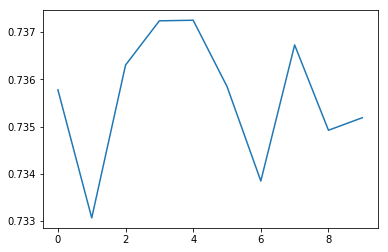

In [70]:
plt.plot(range(epochs),losses)

In [71]:
#validation
with torch.no_grad():
    y_val = model(cat_test,con_test)#can be val in the actual work
    
    loss = torch.sqrt(criterion(y_val,y_test))
loss

tensor(0.8577)

In [75]:
for i in range(10):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')#Change D


tensor([-0.0841,  0.2314])    1      0   
tensor([-0.2958,  0.1653])    1      0   
tensor([-0.1047,  0.0530])    1      0   
tensor([-0.3034, -0.0740])    1      1   
tensor([-0.2400, -0.4383])    0      0   
tensor([-0.0563, -0.5358])    0      0   
tensor([ 0.1661, -0.0394])    0      0   
tensor([-0.6001, -1.1779])    0      1   
tensor([-0.4591,  0.3231])    1      0   
tensor([0.1579, 0.6442])      1      1   


In [152]:
#save model
torch.save(model.state_dict(),'taxiModel.pt')